<a href="https://colab.research.google.com/github/Manjuphoenix/ML_team_buzz/blob/michelle/V7_Tomato_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from collections import Counter

from PIL import Image

import torch
import torchvision
from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler, ConcatDataset



from sklearn.model_selection import train_test_split
from tqdm import tqdm


torch.cuda.empty_cache()

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
#train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

!pip install kaggle

from google.colab import files 
files.upload()

#Make a directory named kaggle and copy the kaggle.json file there; and change its permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#imagenet_data = torchvision.datasets.ImageNet('https://kaggle.com/saroz014/plant-diseases')
#data_loader = torch.utils.data.DataLoader(imagenet_data, batch_size=4, shuffle=True, num_workers=args.nThreads)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


In [7]:
!kaggle datasets download -d manjuphoenix/tomatodataset

100% 923M/923M [00:08<00:00, 95.3MB/s]
100% 923M/923M [00:08<00:00, 110MB/s] 


In [8]:
from zipfile import ZipFile
file_name = 'tomatodataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  #zip.printdir()
  print(zip.extractall())
  #zip.close()
  print('Done')

None
Done


In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
])


device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)
# Uncomment the below line based on where you train the model----------------------------------------
# !mkdir /kaggle/working/Tomato

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Tomato* /kaggle/working/Tomato
# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Tomato* /kaggle/working/Tomato

# !rm -rf /kaggle/working/Tomato/Tomato___Leaf_Mold
# !rm -rf /kaggle/working/Tomato/Tomato___Tomato_mosaic_virus 

# Uncomment this for training on kaggle
# data = datasets.ImageFolder('/kaggle/working/Tomato', transform=transform)----------------------------


# This is for training on Local Machine
data = datasets.ImageFolder('/content/Tomato', transform=transform)


# Split into train/test sets:
train_len = int(len(data)*0.7)
train_set, valid_set = random_split(data, [train_len, len(data) - train_len])

val_len = int(len(valid_set)*0.8)
validation_set, test_set = random_split(valid_set, [val_len, len(valid_set) - val_len])


# Extract classes:
train_classes = [train_set.dataset.targets[i] for i in train_set.indices]
# Calculate support:
class_count = Counter(train_classes)
# Calculate class weights:
class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
# Sampler needs the respective class weight supplied for each image in the dataset:
sample_weights = [class_weights[train_set.dataset.targets[i]] for i in train_set.indices]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(train_set)*2), replacement=True)

batch_size=32

# Create torch dataloaders:

dataloaders = DataLoader(data, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The total number of images is:", len(dataloaders))

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a training set is:", len(train_loader)*batch_size)

val_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a validation set is:", len(val_loader)*batch_size)

test_loader = DataLoader(test_set, batch_size =batch_size, shuffle=True, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a test set is:", len(test_loader)*batch_size)
print(dataloaders.dataset)

print(data.classes)
# x, y = next(iter(dataloaders[0]))

cuda:0
The total number of images is: 2841
The number of images in a training set is: 90912
The number of images in a validation set is: 19488
The number of images in a test set is: 3904
Dataset ImageFolder
    Number of datapoints: 64936
    Root location: /content/Tomato
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomGrayscale(p=0.1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )
['Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']


In [10]:
from torch.autograd import Variable
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=2)
        self.relu2 = nn.LeakyReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32*65*65, 100)
        self.fc2 = nn.Linear(100, 8)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
model = NeuralNetwork()

model = model.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [11]:
model.eval()

NeuralNetwork(
  (cnn): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (relu2): LeakyReLU(negative_slope=0.01)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=135200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=8, bias=True)
)

In [12]:
def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  if accuracy >= 95.:
    print('Model trained to 95% accuracy!')
  else:
    accuracies['train'].append(accuracy)
    losses['train'].append(loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [13]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [15]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-5, momentum=0.6)

In [16]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=60
for epoch in range(1,int(epochs)+1):
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)
  


Epoch : 1


100%|██████████| 2841/2841 [04:15<00:00, 11.11it/s]


Train Loss: 1.950 | Accuracy: 28.846


100%|██████████| 609/609 [00:50<00:00, 11.98it/s]


Test Loss: 1.819 | Accuracy: 35.712

Epoch : 2


100%|██████████| 2841/2841 [04:10<00:00, 11.36it/s]


Train Loss: 1.728 | Accuracy: 39.197


100%|██████████| 609/609 [00:51<00:00, 11.94it/s]


Test Loss: 1.648 | Accuracy: 42.780

Epoch : 3


100%|██████████| 2841/2841 [04:09<00:00, 11.40it/s]


Train Loss: 1.615 | Accuracy: 43.533


100%|██████████| 609/609 [00:51<00:00, 11.74it/s]


Test Loss: 1.590 | Accuracy: 45.901

Epoch : 4


100%|██████████| 2841/2841 [04:10<00:00, 11.36it/s]


Train Loss: 1.546 | Accuracy: 46.545


100%|██████████| 609/609 [00:52<00:00, 11.69it/s]


Test Loss: 1.504 | Accuracy: 50.367

Epoch : 5


100%|██████████| 2841/2841 [04:08<00:00, 11.46it/s]


Train Loss: 1.454 | Accuracy: 50.364


100%|██████████| 609/609 [00:50<00:00, 12.02it/s]


Test Loss: 1.418 | Accuracy: 49.720

Epoch : 6


100%|██████████| 2841/2841 [04:10<00:00, 11.34it/s]


Train Loss: 1.362 | Accuracy: 53.175


100%|██████████| 609/609 [00:51<00:00, 11.85it/s]


Test Loss: 1.326 | Accuracy: 52.985

Epoch : 7


100%|██████████| 2841/2841 [04:10<00:00, 11.36it/s]


Train Loss: 1.277 | Accuracy: 55.459


100%|██████████| 609/609 [00:51<00:00, 11.79it/s]


Test Loss: 1.235 | Accuracy: 56.753

Epoch : 8


100%|██████████| 2841/2841 [04:11<00:00, 11.30it/s]


Train Loss: 1.215 | Accuracy: 57.517


100%|██████████| 609/609 [00:50<00:00, 12.01it/s]


Test Loss: 1.182 | Accuracy: 58.529

Epoch : 9


100%|██████████| 2841/2841 [04:08<00:00, 11.41it/s]


Train Loss: 1.149 | Accuracy: 59.657


100%|██████████| 609/609 [00:50<00:00, 11.99it/s]


Test Loss: 1.118 | Accuracy: 61.398

Epoch : 10


100%|██████████| 2841/2841 [04:11<00:00, 11.30it/s]


Train Loss: 1.097 | Accuracy: 61.274


100%|██████████| 609/609 [00:50<00:00, 11.95it/s]


Test Loss: 1.061 | Accuracy: 63.185

Epoch : 11


100%|██████████| 2841/2841 [04:15<00:00, 11.14it/s]


Train Loss: 1.043 | Accuracy: 63.076


100%|██████████| 609/609 [00:51<00:00, 11.75it/s]


Test Loss: 1.011 | Accuracy: 64.114

Epoch : 12


100%|██████████| 2841/2841 [04:12<00:00, 11.23it/s]


Train Loss: 1.001 | Accuracy: 64.666


100%|██████████| 609/609 [00:51<00:00, 11.74it/s]


Test Loss: 0.966 | Accuracy: 66.023

Epoch : 13


100%|██████████| 2841/2841 [04:10<00:00, 11.33it/s]


Train Loss: 0.964 | Accuracy: 65.691


100%|██████████| 609/609 [00:53<00:00, 11.43it/s]


Test Loss: 0.935 | Accuracy: 67.189

Epoch : 14


100%|██████████| 2841/2841 [04:11<00:00, 11.31it/s]


Train Loss: 0.923 | Accuracy: 67.391


100%|██████████| 609/609 [00:54<00:00, 11.14it/s]


Test Loss: 0.907 | Accuracy: 67.825

Epoch : 15


100%|██████████| 2841/2841 [04:13<00:00, 11.19it/s]


Train Loss: 0.894 | Accuracy: 68.158


100%|██████████| 609/609 [00:53<00:00, 11.45it/s]


Test Loss: 0.901 | Accuracy: 67.435

Epoch : 16


100%|██████████| 2841/2841 [04:13<00:00, 11.21it/s]


Train Loss: 0.863 | Accuracy: 69.109


100%|██████████| 609/609 [00:51<00:00, 11.86it/s]


Test Loss: 0.852 | Accuracy: 69.273

Epoch : 17


100%|██████████| 2841/2841 [04:12<00:00, 11.26it/s]


Train Loss: 0.846 | Accuracy: 69.793


100%|██████████| 609/609 [00:53<00:00, 11.44it/s]


Test Loss: 0.840 | Accuracy: 69.940

Epoch : 18


100%|██████████| 2841/2841 [04:12<00:00, 11.25it/s]


Train Loss: 0.821 | Accuracy: 70.687


100%|██████████| 609/609 [00:51<00:00, 11.77it/s]


Test Loss: 0.800 | Accuracy: 71.588

Epoch : 19


100%|██████████| 2841/2841 [04:10<00:00, 11.34it/s]


Train Loss: 0.809 | Accuracy: 71.041


100%|██████████| 609/609 [00:52<00:00, 11.51it/s]


Test Loss: 0.794 | Accuracy: 71.577

Epoch : 20


100%|██████████| 2841/2841 [04:14<00:00, 11.17it/s]


Train Loss: 0.788 | Accuracy: 71.940


100%|██████████| 609/609 [00:51<00:00, 11.87it/s]


Test Loss: 0.779 | Accuracy: 72.229

Epoch : 21


100%|██████████| 2841/2841 [04:18<00:00, 10.98it/s]


Train Loss: 0.773 | Accuracy: 72.386


100%|██████████| 609/609 [00:53<00:00, 11.38it/s]


Test Loss: 0.753 | Accuracy: 73.292

Epoch : 22


100%|██████████| 2841/2841 [04:14<00:00, 11.15it/s]


Train Loss: 0.760 | Accuracy: 72.764


100%|██████████| 609/609 [00:50<00:00, 12.09it/s]


Test Loss: 0.741 | Accuracy: 73.816

Epoch : 23


100%|██████████| 2841/2841 [04:07<00:00, 11.47it/s]


Train Loss: 0.740 | Accuracy: 73.374


100%|██████████| 609/609 [00:52<00:00, 11.66it/s]


Test Loss: 0.717 | Accuracy: 74.642

Epoch : 24


100%|██████████| 2841/2841 [04:05<00:00, 11.59it/s]


Train Loss: 0.728 | Accuracy: 74.001


100%|██████████| 609/609 [00:49<00:00, 12.24it/s]


Test Loss: 0.730 | Accuracy: 74.026

Epoch : 25


100%|██████████| 2841/2841 [04:02<00:00, 11.71it/s]


Train Loss: 0.714 | Accuracy: 74.463


100%|██████████| 609/609 [00:50<00:00, 11.97it/s]


Test Loss: 0.699 | Accuracy: 75.268

Epoch : 26


100%|██████████| 2841/2841 [04:00<00:00, 11.79it/s]


Train Loss: 0.707 | Accuracy: 74.779


100%|██████████| 609/609 [00:49<00:00, 12.27it/s]


Test Loss: 0.714 | Accuracy: 74.837

Epoch : 27


100%|██████████| 2841/2841 [04:03<00:00, 11.66it/s]


Train Loss: 0.692 | Accuracy: 75.271


100%|██████████| 609/609 [00:49<00:00, 12.38it/s]


Test Loss: 0.676 | Accuracy: 75.920

Epoch : 28


100%|██████████| 2841/2841 [04:02<00:00, 11.71it/s]


Train Loss: 0.685 | Accuracy: 75.670


100%|██████████| 609/609 [00:49<00:00, 12.40it/s]


Test Loss: 0.682 | Accuracy: 75.628

Epoch : 29


100%|██████████| 2841/2841 [04:03<00:00, 11.67it/s]


Train Loss: 0.668 | Accuracy: 76.050


100%|██████████| 609/609 [00:49<00:00, 12.34it/s]


Test Loss: 0.682 | Accuracy: 75.371

Epoch : 30


100%|██████████| 2841/2841 [04:04<00:00, 11.63it/s]


Train Loss: 0.657 | Accuracy: 76.690


100%|██████████| 609/609 [00:51<00:00, 11.93it/s]


Test Loss: 0.664 | Accuracy: 76.777

Epoch : 31


100%|██████████| 2841/2841 [04:01<00:00, 11.76it/s]


Train Loss: 0.651 | Accuracy: 76.746


100%|██████████| 609/609 [00:49<00:00, 12.42it/s]


Test Loss: 0.734 | Accuracy: 73.656

Epoch : 32


100%|██████████| 2841/2841 [04:00<00:00, 11.79it/s]


Train Loss: 0.642 | Accuracy: 77.268


100%|██████████| 609/609 [00:51<00:00, 11.74it/s]


Test Loss: 0.629 | Accuracy: 77.855

Epoch : 33


100%|██████████| 2841/2841 [04:01<00:00, 11.74it/s]


Train Loss: 0.631 | Accuracy: 77.528


100%|██████████| 609/609 [00:49<00:00, 12.43it/s]


Test Loss: 0.620 | Accuracy: 77.727

Epoch : 34


100%|██████████| 2841/2841 [04:02<00:00, 11.73it/s]


Train Loss: 0.621 | Accuracy: 78.024


100%|██████████| 609/609 [00:48<00:00, 12.46it/s]


Test Loss: 0.642 | Accuracy: 77.398

Epoch : 35


100%|██████████| 2841/2841 [04:01<00:00, 11.78it/s]


Train Loss: 0.620 | Accuracy: 78.012


100%|██████████| 609/609 [00:49<00:00, 12.24it/s]


Test Loss: 0.615 | Accuracy: 78.040

Epoch : 36


100%|██████████| 2841/2841 [04:01<00:00, 11.79it/s]


Train Loss: 0.604 | Accuracy: 78.625


100%|██████████| 609/609 [00:49<00:00, 12.30it/s]


Test Loss: 0.598 | Accuracy: 78.661

Epoch : 37


100%|██████████| 2841/2841 [04:01<00:00, 11.75it/s]


Train Loss: 0.599 | Accuracy: 78.580


100%|██████████| 609/609 [00:49<00:00, 12.27it/s]


Test Loss: 0.595 | Accuracy: 79.128

Epoch : 38


100%|██████████| 2841/2841 [04:00<00:00, 11.79it/s]


Train Loss: 0.589 | Accuracy: 79.133


100%|██████████| 609/609 [00:51<00:00, 11.84it/s]


Test Loss: 0.571 | Accuracy: 80.037

Epoch : 39


100%|██████████| 2841/2841 [04:00<00:00, 11.83it/s]


Train Loss: 0.580 | Accuracy: 79.497


100%|██████████| 609/609 [00:51<00:00, 11.86it/s]


Test Loss: 0.614 | Accuracy: 77.994

Epoch : 40


100%|██████████| 2841/2841 [04:03<00:00, 11.69it/s]


Train Loss: 0.573 | Accuracy: 79.695


100%|██████████| 609/609 [00:49<00:00, 12.30it/s]


Test Loss: 0.562 | Accuracy: 79.698

Epoch : 41


100%|██████████| 2841/2841 [04:02<00:00, 11.73it/s]


Train Loss: 0.572 | Accuracy: 79.727


100%|██████████| 609/609 [00:49<00:00, 12.40it/s]


Test Loss: 0.573 | Accuracy: 79.939

Epoch : 42


100%|██████████| 2841/2841 [04:01<00:00, 11.77it/s]


Train Loss: 0.564 | Accuracy: 80.035


100%|██████████| 609/609 [00:49<00:00, 12.40it/s]


Test Loss: 0.572 | Accuracy: 79.678

Epoch : 43


100%|██████████| 2841/2841 [04:01<00:00, 11.76it/s]


Train Loss: 0.560 | Accuracy: 80.284


100%|██████████| 609/609 [00:48<00:00, 12.49it/s]


Test Loss: 0.566 | Accuracy: 79.667

Epoch : 44


100%|██████████| 2841/2841 [04:01<00:00, 11.78it/s]


Train Loss: 0.545 | Accuracy: 80.744


100%|██████████| 609/609 [00:50<00:00, 11.95it/s]


Test Loss: 0.541 | Accuracy: 80.894

Epoch : 45


100%|██████████| 2841/2841 [04:00<00:00, 11.80it/s]


Train Loss: 0.544 | Accuracy: 80.917


100%|██████████| 609/609 [00:49<00:00, 12.40it/s]


Test Loss: 0.545 | Accuracy: 80.602

Epoch : 46


100%|██████████| 2841/2841 [04:03<00:00, 11.69it/s]


Train Loss: 0.539 | Accuracy: 81.038


100%|██████████| 609/609 [00:49<00:00, 12.36it/s]


Test Loss: 0.541 | Accuracy: 81.028

Epoch : 47


100%|██████████| 2841/2841 [04:03<00:00, 11.65it/s]


Train Loss: 0.533 | Accuracy: 81.189


100%|██████████| 609/609 [00:49<00:00, 12.27it/s]


Test Loss: 0.525 | Accuracy: 81.844

Epoch : 48


100%|██████████| 2841/2841 [04:05<00:00, 11.59it/s]


Train Loss: 0.527 | Accuracy: 81.573


100%|██████████| 609/609 [00:50<00:00, 12.13it/s]


Test Loss: 0.523 | Accuracy: 81.336

Epoch : 49


100%|██████████| 2841/2841 [04:04<00:00, 11.60it/s]


Train Loss: 0.525 | Accuracy: 81.661


100%|██████████| 609/609 [00:52<00:00, 11.65it/s]


Test Loss: 0.521 | Accuracy: 81.952

Epoch : 50


100%|██████████| 2841/2841 [04:06<00:00, 11.55it/s]


Train Loss: 0.514 | Accuracy: 81.882


100%|██████████| 609/609 [00:49<00:00, 12.38it/s]


Test Loss: 0.509 | Accuracy: 82.085

Epoch : 51


100%|██████████| 2841/2841 [04:02<00:00, 11.73it/s]


Train Loss: 0.518 | Accuracy: 81.812


100%|██████████| 609/609 [00:50<00:00, 12.15it/s]


Test Loss: 0.515 | Accuracy: 82.116

Epoch : 52


100%|██████████| 2841/2841 [03:59<00:00, 11.84it/s]


Train Loss: 0.512 | Accuracy: 81.991


100%|██████████| 609/609 [00:48<00:00, 12.44it/s]


Test Loss: 0.527 | Accuracy: 81.408

Epoch : 53


100%|██████████| 2841/2841 [04:01<00:00, 11.75it/s]


Train Loss: 0.506 | Accuracy: 82.193


100%|██████████| 609/609 [00:48<00:00, 12.46it/s]


Test Loss: 0.607 | Accuracy: 78.733

Epoch : 54


100%|██████████| 2841/2841 [04:01<00:00, 11.78it/s]


Train Loss: 0.504 | Accuracy: 82.412


100%|██████████| 609/609 [00:48<00:00, 12.46it/s]


Test Loss: 0.513 | Accuracy: 81.495

Epoch : 55


100%|██████████| 2841/2841 [04:00<00:00, 11.79it/s]


Train Loss: 0.500 | Accuracy: 82.379


100%|██████████| 609/609 [00:48<00:00, 12.45it/s]


Test Loss: 0.518 | Accuracy: 81.803

Epoch : 56


100%|██████████| 2841/2841 [04:01<00:00, 11.75it/s]


Train Loss: 0.491 | Accuracy: 82.769


100%|██████████| 609/609 [00:49<00:00, 12.35it/s]


Test Loss: 0.556 | Accuracy: 80.530

Epoch : 57


100%|██████████| 2841/2841 [04:01<00:00, 11.77it/s]


Train Loss: 0.494 | Accuracy: 82.654


100%|██████████| 609/609 [00:49<00:00, 12.22it/s]


Test Loss: 0.507 | Accuracy: 82.101

Epoch : 58


100%|██████████| 2841/2841 [04:00<00:00, 11.82it/s]


Train Loss: 0.487 | Accuracy: 82.890


100%|██████████| 609/609 [00:50<00:00, 12.18it/s]


Test Loss: 0.486 | Accuracy: 83.302

Epoch : 59


100%|██████████| 2841/2841 [04:00<00:00, 11.80it/s]


Train Loss: 0.490 | Accuracy: 82.908


100%|██████████| 609/609 [00:49<00:00, 12.36it/s]


Test Loss: 0.481 | Accuracy: 83.271

Epoch : 60


100%|██████████| 2841/2841 [04:01<00:00, 11.75it/s]


Train Loss: 0.479 | Accuracy: 83.206


100%|██████████| 609/609 [00:50<00:00, 12.06it/s]

Test Loss: 0.492 | Accuracy: 82.624


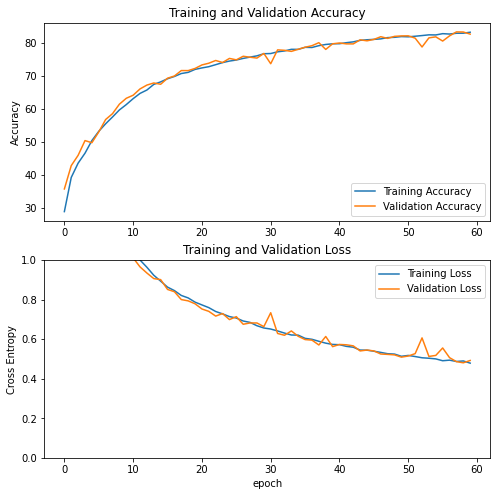

In [17]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [18]:
#Testing classification accuracy for individual classes.
classes = ['Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
c = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze()
        # print(c)
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print(c.type())
for i in range(8):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

torch.cuda.BoolTensor
Accuracy of Tomato_Target_spot : 69 %
Accuracy of Tomato__Late_blight : 67 %
Accuracy of Tomato__Septoria_leaf_spot : 78 %
Accuracy of Tomato__Spider_mites : 86 %
Accuracy of Tomato___Bacterial_spot : 95 %
Accuracy of Tomato___Tomato_Yellow_Leaf_Curl_Virus : 92 %
Accuracy of Tomato__early_blight : 69 %
Accuracy of Tomato__healthy : 93 %


In [19]:
avg = 0
for i in range(8):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/8
print('Average accuracy = ', avg)

Average accuracy =  81.71089497003224


In [20]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/v4_tomato.pk1')
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('/content/gdrive/MyDrive/v4_tomato_scripted.pt') # Save

[[331   3   8  85   3   0  19   8]
 [  3 359  16  20   5   4  70   5]
 [ 15  40 384  20   4   2  23   8]
 [ 27   3   5 386   3   3  33   5]
 [  1   4   1   1 487  12   5   0]
 [  1  11   0   1  16 468   4   0]
 [ 14  57  21  37   6   3 354   0]
 [ 11  11   2  16   2   0   0 451]]
[72.42888403 74.4813278  77.41935484 83.01075269 95.30332681 93.41317365
 71.95121951 91.48073022]


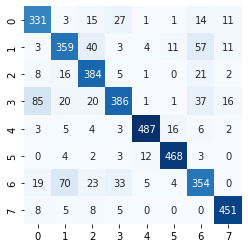

In [21]:
from sklearn.metrics import confusion_matrix

nb_classes = 8

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix_confusion = confusion_matrix(predlist, lbllist)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)